# 地图数据处理及可视化

- 知识点：地理数据读取、处理、坐标系转换及绘图

- 工具：geopandas, descartes, mapclassify, cartopy

## 中国每个省级单位有多少个邻居

In [1]:
import geopandas as gpd

In [2]:
s = gpd.read_file('../shp_file/china.shp',encoding='utf8')

In [3]:
s

,AREA,BOUND_A_,BOUND_A_ID,FCNAME,FENAME,NAME,OWNER,PERIMETER,SOC,geometry
0,54.482100,6,5,黑龙江省,Heilongjiang Sheng,None,黑龙江省,70.132800,CHN,"POLYGON ((121.48938 53.33117, 121.49162 53.331..."
1,129.067000,7,6,内蒙古自治区,Neimongol Zizhiqu,None,内蒙古自治区,133.994000,CHN,"POLYGON ((121.48938 53.33117, 121.49769 53.320..."
2,175.086000,23,26,新疆维吾尔自治区,Xinjianguygur Zizhiqu,None,新疆维吾尔自治区,86.087100,CHN,"POLYGON ((87.31262 49.10914, 87.31808 49.10807..."
3,21.306600,54,59,吉林省,Jilin Sheng,None,吉林省,43.298200,CHN,"POLYGON ((123.17773 46.24767, 123.18046 46.248..."
4,15.589100,107,122,辽宁省,Liaoning Sheng,None,辽宁省,40.620300,CHN,"POLYGON ((125.70507 40.86603, 125.69979 40.864..."
...,...,...,...,...,...,...,...,...,...,...
1362,0.002047,5673,5865,南安礁,Nan an Jiao,None,海南省,0.168232,CHN,"POLYGON ((112.57276 5.12172, 112.59740 5.12087..."
1363,0.002346,5679,5871,南安礁,Nan an Jiao,None,海南省,0.180429,CHN,"POLYGON ((112.92490 5.05133, 112.93376 5.05235..."
1364,0.001124,5786,5985,曾母暗沙,Zengmu Ansha,None,海南省,0.120940,CHN,"POLYGON ((112.27734 3.97014, 112.28036 3.96595..."
1365,0.001574,5793,5992,曾母暗沙,Zengmu Ansha,None,海南省,0.142934,CHN,"POLYGON ((112.26261 3.87938, 112.26217 3.87351..."


In [4]:
s.OWNER.unique(),len(s.OWNER.unique())

(array(['黑龙江省', '内蒙古自治区', '新疆维吾尔自治区', '吉林省', '辽宁省', '甘肃省', '河北省', '北京市',
        '山西省', '天津市', '陕西省', '宁夏回族自治区', '青海省', '山东省', '西藏自治区', '河南省',
        '江苏省', '安徽省', '四川省', '湖北省', '重庆市', '上海市', '浙江省', '湖南省', '江西省',
        '云南省', '贵州省', '福建省', '广西壮族自治区', '台湾省', '广东省', '香港特别行政区', '澳门特别行政区',
        '海南省'], dtype=object),
 34)

我们先定义一个函数来把省的名字精简成两、三个字

In [5]:
def shorten_prov_names(prov_name:str) -> str:   # Type hint, valid for python version >= 3.5
    if ('自' in prov_name or '特' in prov_name) and prov_name != '内蒙古自治区':
        name = prov_name[:2]
    else:
        name = prov_name.replace('省', '').replace('市', '').replace('自治区', '')
    return name

In [6]:
s.OWNER = s.OWNER.apply(shorten_prov_names)

接着，我们利用 `dissolve` 方法将多个多边形合并（即将每个省级单位的多个条目进行合并）

In [7]:
provinces = s.dissolve(by='OWNER').reset_index()

In [8]:
provinces = provinces.drop(['AREA','BOUND_A_','BOUND_A_ID','NAME',
                            'SOC','FCNAME','FENAME','PERIMETER'],axis=1)

最后，利用 `geoDataFrame.geometry` 的几何关系判断方法（`touches`）来决定某两个省级单位是否相邻，并在 `provinces` 里面插入两个新列，分别存储每个省的领据列表和总数。

In [9]:
for index, row in provinces.iterrows():
    neighbors = provinces[provinces.geometry.touches(row['geometry'])].OWNER.tolist() 
    #neighbors = neighbors.remove(row.OWNER)
    provinces.at[index, "neighbors"] = ", ".join(neighbors)
    provinces.at[index, "neighbors_num"] = len(neighbors)
    
provinces["neighbors_num"] = provinces["neighbors_num"].astype('int')

In [10]:
provinces.sort_values(by='neighbors_num',ascending=False)

,OWNER,geometry,neighbors,neighbors_num
2,内蒙古,"POLYGON ((121.48938 53.33117, 121.49769 53.320...","吉林, 宁夏, 山西, 河北, 甘肃, 辽宁, 陕西, 黑龙江",8
30,陕西,"POLYGON ((111.11640 39.36374, 111.11701 39.363...","内蒙古, 四川, 宁夏, 山西, 河南, 湖北, 甘肃, 重庆",8
17,河北,"MULTIPOLYGON (((119.14247 39.30547, 119.14012 ...","内蒙古, 北京, 天津, 山东, 山西, 河南, 辽宁",7
6,四川,"POLYGON ((105.49535 32.91074, 105.49502 32.905...","云南, 甘肃, 西藏, 贵州, 重庆, 陕西, 青海",7
16,江西,"POLYGON ((118.18945 29.39522, 118.19344 29.386...","安徽, 广东, 浙江, 湖北, 湖南, 福建",6
24,甘肃,"POLYGON ((97.17195 42.79342, 97.18481 42.77167...","内蒙古, 四川, 宁夏, 新疆, 陕西, 青海",6
22,湖南,"POLYGON ((113.94013 29.04828, 113.93997 29.044...","广东, 广西, 江西, 湖北, 贵州, 重庆",6
9,安徽,"POLYGON ((116.36870 34.64072, 116.37081 34.639...","山东, 江苏, 江西, 河南, 浙江, 湖北",6
21,湖北,"MULTIPOLYGON (((110.97766 33.25967, 110.98971 ...","安徽, 江西, 河南, 湖南, 重庆, 陕西",6
12,广东,"MULTIPOLYGON (((109.93091 20.22808, 109.93093 ...","广西, 江西, 湖南, 澳门, 福建, 香港",6


大家可以将这个结果和 https://www.sohu.com/a/355921579_353978 对照一下，看看结果是否正确。

## 地图标注、填色

<GeoAxesSubplot:>

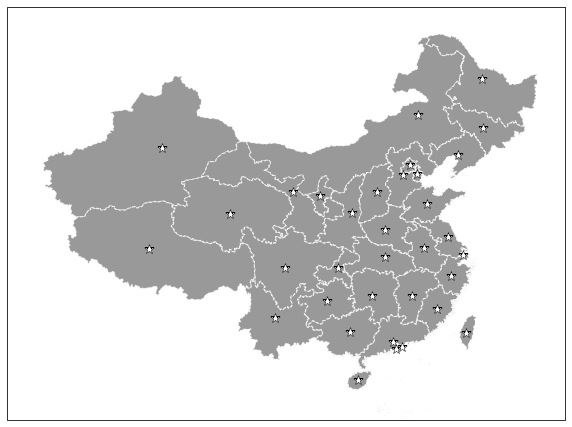

In [11]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

#crs = ccrs.LambertConformal(central_longitude=105.) #AzimuthalEqualArea()
crs = ccrs.LambertAzimuthalEqualArea(central_longitude=105.)

fig,ax = plt.subplots(figsize=(10,8),subplot_kw={'projection': crs})
provinces.plot(ax=ax, facecolor='grey', edgecolor='white', linestyle='--', alpha=0.8, transform=ccrs.PlateCarree())
ax.patch.set_visible(False)
ax.set_extent([75,130,15,54])
provinces.geometry.representative_point().plot(ax=ax, facecolor='white', edgecolor='black', 
                                               marker='*', markersize=100, linewidth=0.5,
                                               transform=ccrs.PlateCarree())

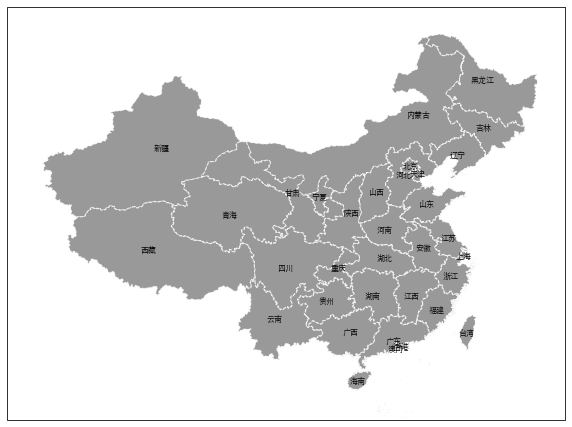

In [12]:
import matplotlib as mpl
# 请使用你的电脑上的字体文件
myfont = mpl.font_manager.FontProperties(fname='/System/Library/Fonts/STHeiti Light.ttc')

fig,ax = plt.subplots(figsize=(10,8),subplot_kw={'projection': crs})
provinces.plot(ax=ax, facecolor='grey', edgecolor='white', linestyle='--', alpha=0.8, transform=ccrs.PlateCarree())
ax.patch.set_visible(False)
ax.set_extent([75,130,15,54])

for index, row in provinces.iterrows():
    ax.text(row.geometry.representative_point().x, row.geometry.representative_point().y,
            row['OWNER'], ha="center", va="center", size=8, transform=ccrs.PlateCarree(),
            fontproperties=myfont)

我们来获取 COVID-19 确诊信息，并把每个省的累计确诊数据画到地图上。 

腾讯提供了实时疫情信息，我们可以从该网页分析出其输出数据的实际网址和参数（利用 Chrome 或者 Firefox 的开发者工具）。

In [13]:
import requests, json

url = 'https://view.inews.qq.com/g2/getOnsInfo?name=disease_h5'

req = requests.get(url)

In [14]:
data = req.json()

In [15]:
data.keys()

dict_keys(['ret', 'data'])

In [16]:
data['data']

'{"lastUpdateTime":"2021-01-01 17:28:36","chinaTotal":{"confirm":96762,"heal":90597,"dead":4789,"nowConfirm":1376,"suspect":1,"nowSevere":9,"importedCase":4273,"noInfect":279},"chinaAdd":{"confirm":89,"heal":113,"dead":1,"nowConfirm":-25,"suspect":1,"nowSevere":3,"importedCase":10,"noInfect":19},"isShowAdd":true,"showAddSwitch":{"all":true,"confirm":true,"suspect":true,"dead":true,"heal":true,"nowConfirm":true,"nowSevere":true,"importedCase":true,"noInfect":true},"areaTree":[{"name":"中国","today":{"confirm":89,"isUpdated":true},"total":{"nowConfirm":1376,"confirm":96762,"suspect":1,"dead":4789,"deadRate":"4.95","showRate":false,"heal":90597,"healRate":"93.63","showHeal":true},"children":[{"name":"香港","today":{"confirm":68,"confirmCuts":0,"isUpdated":true,"tip":""},"total":{"nowConfirm":885,"confirm":8846,"suspect":0,"dead":148,"deadRate":"1.67","showRate":false,"heal":7813,"healRate":"88.32","showHeal":true},"children":[{"name":"地区待确认","today":{"confirm":68,"confirmCuts":0,"isUpdated":t

In [17]:
china_data = json.loads(data['data'])

china_data.keys()

dict_keys(['lastUpdateTime', 'chinaTotal', 'chinaAdd', 'isShowAdd', 'showAddSwitch', 'areaTree'])

In [18]:
china_data['areaTree']

[{'name': '中国',
  'today': {'confirm': 89, 'isUpdated': True},
  'total': {'nowConfirm': 1376,
   'confirm': 96762,
   'suspect': 1,
   'dead': 4789,
   'deadRate': '4.95',
   'showRate': False,
   'heal': 90597,
   'healRate': '93.63',
   'showHeal': True},
  'children': [{'name': '香港',
    'today': {'confirm': 68, 'confirmCuts': 0, 'isUpdated': True, 'tip': ''},
    'total': {'nowConfirm': 885,
     'confirm': 8846,
     'suspect': 0,
     'dead': 148,
     'deadRate': '1.67',
     'showRate': False,
     'heal': 7813,
     'healRate': '88.32',
     'showHeal': True},
    'children': [{'name': '地区待确认',
      'today': {'confirm': 68, 'confirmCuts': 0, 'isUpdated': True},
      'total': {'nowConfirm': 885,
       'confirm': 8846,
       'suspect': 0,
       'dead': 148,
       'deadRate': '1.67',
       'showRate': False,
       'heal': 7813,
       'healRate': '88.32',
       'showHeal': True}}]},
   {'name': '台湾',
    'today': {'confirm': 2, 'confirmCuts': 0, 'isUpdated': True, 'tip'

In [19]:
china_data['areaTree'][0].keys()

dict_keys(['name', 'today', 'total', 'children'])

In [20]:
for item in china_data['areaTree'][0].get('children'):
    print(item['name'],': ', item['total']['confirm'])

香港 :  8846
台湾 :  799
上海 :  1516
辽宁 :  351
北京 :  987
广东 :  2046
四川 :  853
福建 :  513
内蒙古 :  364
陕西 :  507
云南 :  230
浙江 :  1306
黑龙江 :  964
山东 :  862
河南 :  1299
天津 :  309
山西 :  224
江苏 :  684
安徽 :  993
广西 :  264
湖南 :  1021
宁夏 :  75
青海 :  18
吉林 :  157
澳门 :  46
海南 :  171
新疆 :  980
西藏 :  1
重庆 :  590
湖北 :  68149
江西 :  935
河北 :  373
甘肃 :  182
贵州 :  147


In [21]:
prov_confirm = dict()

prov_confirm = {item['name']: int(item['total']['confirm'])
                    for item in china_data['areaTree'][0].get('children')}

In [22]:
prov_confirm

{'香港': 8846,
 '台湾': 799,
 '上海': 1516,
 '辽宁': 351,
 '北京': 987,
 '广东': 2046,
 '四川': 853,
 '福建': 513,
 '内蒙古': 364,
 '陕西': 507,
 '云南': 230,
 '浙江': 1306,
 '黑龙江': 964,
 '山东': 862,
 '河南': 1299,
 '天津': 309,
 '山西': 224,
 '江苏': 684,
 '安徽': 993,
 '广西': 264,
 '湖南': 1021,
 '宁夏': 75,
 '青海': 18,
 '吉林': 157,
 '澳门': 46,
 '海南': 171,
 '新疆': 980,
 '西藏': 1,
 '重庆': 590,
 '湖北': 68149,
 '江西': 935,
 '河北': 373,
 '甘肃': 182,
 '贵州': 147}

`apply()` 和 `map()` 类似，但是可以同时处理多列数据。此处我们用 `apply()` 来将每个省的确诊数据放入 `provinces` 中作为一列。 

In [23]:
provinces['confirmed_cases'] = provinces['OWNER'].apply(lambda name: prov_confirm[name])

In [24]:
provinces

,OWNER,geometry,neighbors,neighbors_num,confirmed_cases
0,上海,"MULTIPOLYGON (((121.42117 30.68613, 121.42240 ...","江苏, 浙江",2,1516
1,云南,"POLYGON ((105.30025 27.70911, 105.29577 27.698...","四川, 广西, 西藏, 贵州",4,230
2,内蒙古,"POLYGON ((121.48938 53.33117, 121.49769 53.320...","吉林, 宁夏, 山西, 河北, 甘肃, 辽宁, 陕西, 黑龙江",8,364
3,北京,"POLYGON ((117.37974 40.22687, 117.38528 40.223...","天津, 河北",2,987
4,台湾,"MULTIPOLYGON (((120.81553 21.75681, 120.81743 ...",,0,799
5,吉林,"POLYGON ((123.17773 46.24767, 123.18046 46.248...","内蒙古, 辽宁, 黑龙江",3,157
6,四川,"POLYGON ((105.49535 32.91074, 105.49502 32.905...","云南, 甘肃, 西藏, 贵州, 重庆, 陕西, 青海",7,853
7,天津,"MULTIPOLYGON (((117.69566 39.00026, 117.69897 ...","北京, 河北",2,309
8,宁夏,"MULTIPOLYGON (((106.05062 35.45260, 106.04993 ...","内蒙古, 甘肃, 陕西",3,75
9,安徽,"POLYGON ((116.36870 34.64072, 116.37081 34.639...","山东, 江苏, 江西, 河南, 浙江, 湖北",6,993


### `GeoDataFrame.plot` 方法参数

- `column`：用于指定映射地图视觉元素的数值信息，可以是对应`GeoDataFrame`的列名，或是直接传入与几何对象一一对应得数值序列，默认为`None`

- `cmap`：传入色彩方案

- `categorical`：`bool`型，`True`表示指定映射目标列采取离散表示，对于数值型的列有意义，当对应目标列为类别型时自动变为`True`

- `legend`：`bool`型，为`True`时会为地图添加图例

- `scheme`：`str`型，用于指定地区分布图颜色的数值划分方案

- `k`：`int`型，用于指定地图绘色的色阶数量

- `vmin`,`vmax`：`None`或`float`，用于指定绘图的数值范围下限和上限，默认为`None`即以对应数据中的最小/大值为下限

- `legend_kwds`：字典型，传入与图例相关的个性化参数

- `classification_kwds`：字典型，传入与划分绘图颜色相关的个性化参数

- `missing_kwds`：字典型，传入与缺失值处理相关的个性化参数，用于对缺失值部分的做个性化设置

- 地区分布图（Choropleth Map），指的是依据指定属性进行层次划分，并将对应的层次映射到对应几何对象的色彩之上。

- 这里我们将各省的确诊病例数目画成地区分布图。

- 为了对确诊数量进行分级，我们需要使用上面提到的 `scheme` 参数。它会调用外部包 `mapclassify`。

- `mapclassify` 提供多种分层方法，包括自然断点法（`NaturalBreaks`）、箱线图（`BoxPlot`）、等间距（`EqualInterval`）、分位数（`Quantiles`）和用户自定义（`Userdefined`）。

- 我们使用用户自定义方式，将病例数分位 9，99，999，9999 等几档

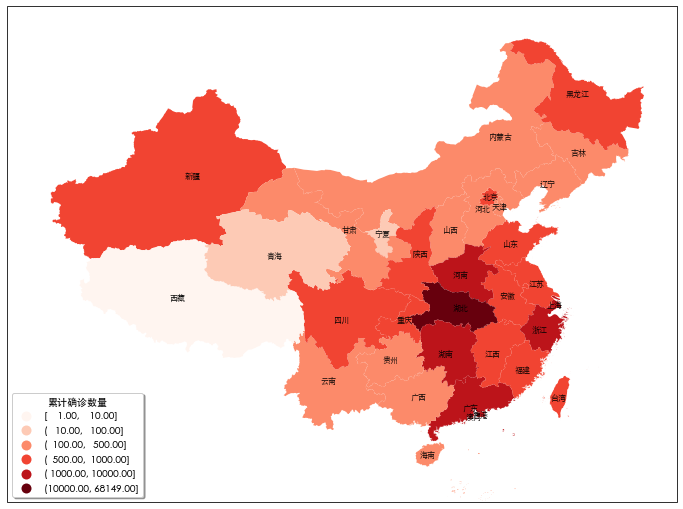

In [25]:
# 请使用你的电脑上的字体文件
font_name = '/System/Library/Fonts/STHeiti Light.ttc'
myfont = mpl.font_manager.FontProperties(fname=font_name)
plt.rcParams["font.family"] = "Heiti TC"        # 字体文件名和字体名不同

fig,ax = plt.subplots(figsize=(12,12),subplot_kw={'projection': crs})
provinces.plot(ax=ax,column='confirmed_cases', cmap='Reds', legend=True, 
               scheme='UserDefined', classification_kwds={'bins':[10, 100, 500, 1000, 10000]},
               legend_kwds={'loc':'lower left','title':'累计确诊数量',
                            'shadow':True,'fancybox':True}, #'prop':{'font.family':'Heiti TC'}},
               transform=ccrs.PlateCarree())
ax.patch.set_visible(False)
ax.set_extent([75,130,15,54])

for index, row in provinces.iterrows():
    ax.text(row.geometry.representative_point().x, row.geometry.representative_point().y,
            row['OWNER'], ha="center", va="center", size=8, transform=ccrs.PlateCarree(),
            fontproperties=myfont)

### 绘制疫情的南丁格尔玫瑰图 （Nightingale Rose)

posx and posy should be finite values
posx and posy should be finite values


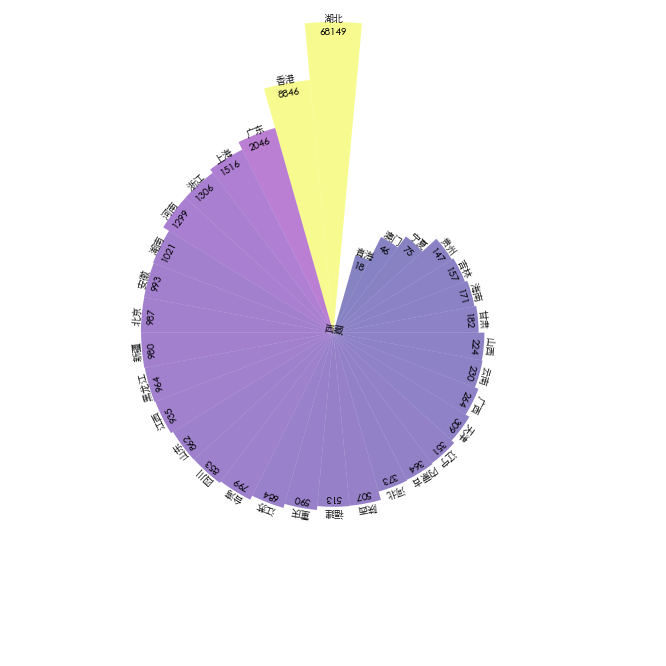

In [26]:
import numpy as np

sorted_pro = provinces.sort_values(by='confirmed_cases',ascending=False)
cases = np.log(sorted_pro.confirmed_cases.values)
N = len(sorted_pro)
theta = np.arange(0,2*np.pi,2*np.pi/N)
width = 2*np.pi / (N)
num = sorted_pro.confirmed_cases
colors = plt.cm.plasma(num/np.max(num[1:]))

fig, ax = plt.subplots(figsize=(12,12),subplot_kw={'projection':'polar'})
ax.set_theta_zero_location("N")
bars = ax.bar(theta, cases, width=width, bottom=0, color=colors,alpha=0.5)
ax.axis('off')

rotations = np.rad2deg(theta)
for x, bar, rotation, label, label_num in zip(theta,
       bars, rotations, sorted_pro.OWNER.values, sorted_pro.confirmed_cases.values):
    lab = ax.text(x, bar.get_height(), label,
             ha='center', va='bottom', fontproperties=myfont,rotation=rotation, rotation_mode="anchor")
    lab = ax.text(x, bar.get_height()-0.2, str(label_num),
             ha='center', va='top', rotation=rotation, rotation_mode="anchor")

### 课后练习
- 返回的数据里有各个省级单位下面的市、县的数据。尝试画一画你所在省的确诊病例分布图（如果需要市、县级地图，可以联系我）。

- https://view.inews.qq.com/g2/getOnsInfo?name=disease_foreign 返回国外病例数据。尝试画一画世界的病例分布。

## References

https://www.cnblogs.com/feffery/p/12361421.html (强烈推荐此博客的文章)